In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
train = pd.read_csv("spam_train.txt",header = None, names = ['email'])
test = pd.read_csv("spam_test.txt", header = None, names = ['email'])

In [3]:
train['spam']=train.applymap(lambda x: x.split(' ')[0]).replace(['0','1'],[int(-1),int(1)])
train['email'] = train['email'].map(lambda x: x[2:])
test['spam']=test.applymap(lambda x: x.split(' ')[0]).replace(['0','1'],[int(-1),int(1)])
test['email'] = test['email'].map(lambda x: x[2:])
train['email'] = train['email'].str.lower()
test['email'] = test['email'].str.lower()

1 (3 points) This problem set will involve your implementing several variants of the Perceptron algorithm discussed in Section 1 and Lecture 2. Before you can build these models and
measure their performance, split your training data (i.e. spam train.txt) into a training and validate set, putting the last 1000 emails into the validation set. Thus, you will have
a new training set with 4000 emails and a validation set with 1000 emails. You will not
use spam test.txt until problem 10.
Explain why measuring the performance of your final classifier would be problematic had
you not created this validation set.

Answer 1:  
We have to create this validation set because we use training data to fit model and validation set for tuning. Tuning is very important because it is essential in finding better parameters/configurations that optimize the model performance.

In [4]:
#Split into new training set and validation set
train_new,train_val = train[:4000],train[4000:]

2 (6 points) Transform all of the data into feature vectors. Build a vocabulary list using
only the 4000 e-mail training set by finding all words that occur across the training set.
Note that we assume that the data in the validation and test sets is completely unseen
when we train our model, and thus we do not use any information contained in them.
Ignore all words that appear in fewer than X = 30 e-mails of the 4000 e-mail training set –
this is both a means of preventing overfitting and of improving scalability. For each email,
transform it into a feature vector ~x where the ith entry, xi
, is 1 if the ith word in the
vocabulary occurs in the email, and 0 otherwise.

In [5]:
def vocabulary(library,n):
    vcb = {}
    for line in library:
        l = []
        for word in line.split(' '):
            if word not in l:
                l.append(word)
        for i in l:
             if len(i) > 0:
                if i in vcb:
                    vcb[i]+=1
                else:
                    vcb[i]=1
    del_v = [word for word in vcb if vcb[word] < n ]
    for d in del_v:
        vcb.pop(d)
    return sorted(vcb, key=vcb.__getitem__,reverse=True)

In [6]:
vcb_train = vocabulary(train_new.iloc[:,0],30)

In [7]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    texts=texts.str.split(' ')
    indicator_array = np.array([texts.str.contains(word,regex=False) for word in words])
    indicator_array =indicator_array.T.astype('int32')
    return indicator_array

3 (12 points) Implement the functions perceptron train(data) and perceptron test(w,
data).
The function perceptron train(data) trains a perceptron classifier using the examples
provided to the function, and should return ~w, k, and iter, the final classification vector,
the number of updates (mistakes) performed, and the number of passes through the data,
respectively. You may assume that the input data provided to your function is linearly
separable (so the stopping criterion should be that all points are correctly classified).
For this exercise, you do not need to add an offset feature to the feature vector (it turns
out not to improve classification accuracy, possibly because a frequently occurring word
already serves this purpose). Your implementation should cycle through the data points in
the order as given in the data files (rather than randomizing), so that results are consistent
for grading purposes.
The function perceptron test(w, data) should take as input the weight vector ~w (the
classification vector to be used) and a set of examples. The function should return the test
error, i.e. the fraction of examples that are misclassified by ~w.


In [8]:
#x is the indicator array obtained from last step
x_train = words_in_texts(vcb_train,pd.Series(train_new.iloc[:,0]))
x_val = words_in_texts(vcb_train,pd.Series(train_val.iloc[:,0]))
#y is the spam column from training data
y_train = train_new.loc[:,'spam']
y_val = train_val.loc[:,'spam']

In [9]:
def perceptron_train(x,y,max_iterr):
    w = np.zeros(len(x[0,:]))
    k = 0
    t = 0 
    boo = False
    while boo==False and (t <= max_iterr):
        t+=1
        boo = True
        for i in range(len(y)):
            if y[i]*np.dot(w.T,x[i]) <=0 and sum(x[i])!=0:
                w=w+y[i]*x[i]
                k+=1
                boo = False
    return w, k, t

In [10]:
def perceptron_test(w,x,y):
    yhat = [1 if np.dot(w.T,x[j]) >= 0.0 else -1 for j in range(len(y))]
    n=0
    error = float(sum(yhat!=y))/len(y)
    return error

4 (6 points) Train the linear classifier using your training set. How many mistakes are
made before the algorithm terminates? Test your implementation of perceptron test by
running it with the learned parameters and the training data, making sure that the training
error is zero. Next, classify the emails in your validation set. What is the validation error?

In [11]:
#validation set
weights,k_mistake,t_iter = perceptron_train(x_train,y_train,20)
y_val = y_val.reset_index(drop = True)
print("mistake made before converging:", k_mistake)
print("iteration before converging:", t_iter)
print("validation test error:", perceptron_test(weights,x_val,y_val))

mistake made before converging: 437
iteration before converging: 11
validation test error: 0.013


5 (3 points) To better understand how the spam classifier works, we can inspect the parameters to see which words the classifier thinks are the most predictive of spam. Using
the vocabulary list together with the parameters learned in the previous question, output
the 15 words with the most positive weights. What are they? Which 15 words have the
most negative weights?


In [12]:
word_weights = pd.DataFrame(list(zip(vcb_train,weights)),columns = ['word','weight'])
most_pos = word_weights.sort_values(by = 'weight', ascending = 0)[:15]
most_neg = word_weights.sort_values(by = 'weight', ascending = 0)[-15:]
print("The most positive words are :", most_pos.values)
print("The most negative words are :", most_neg.values)

The most positive words are : [['sight' 22.0]
 ['click' 18.0]
 ['remov' 16.0]
 ['market' 16.0]
 ['these' 16.0]
 ['our' 15.0]
 ['deathtospamdeathtospamdeathtospam' 14.0]
 ['most' 13.0]
 ['ever' 12.0]
 ['parti' 12.0]
 ['yourself' 12.0]
 ['present' 12.0]
 ['guarante' 11.0]
 ['am' 11.0]
 ['pleas' 11.0]]
The most negative words are : [['coupl' -10.0]
 ['date' -10.0]
 ['url' -10.0]
 ['recipi' -11.0]
 ['someth' -11.0]
 ['comput' -11.0]
 ['which' -11.0]
 ['but' -11.0]
 ['technolog' -12.0]
 ['i' -12.0]
 ['still' -12.0]
 ['copyright' -13.0]
 ['prefer' -14.0]
 ['reserv' -15.0]
 ['wrote' -16.0]]


6 (6 points) Implement the averaged perceptron algorithm, which is the same as your current implementation but which, rather than returning the final weight vector, returns the
average of all weight vectors considered during the algorithm (including examples where
no mistake was made). Averaging reduces the variance between the different vectors, and
is a powerful means of preventing the learning algorithm from overfitting (serving as a type
of regularization).

In [13]:
def perceptron_train_avg(x,y,max_iterr):
    w,w_vec = np.zeros(len(x[0,:])),np.zeros(len(x[0,:]))
    k = 0
    t = 0
    boo = False
    while boo ==False and (t <= max_iterr):
        yhat = [1 if np.dot(w.T,x[j]) >= 0.0 else -1 for j in range(len(y))]
        boo = np.allclose(yhat, y)
        t+=1
        for i in range(len(y)):
            w_vec += w
            if y[i]*np.dot(w.T,x[i]) <=0 and sum(x[i])!=0:
                w=w+y[i]*x[i]
                k+=1
    
    return w_vec/(len(y)*t), k, t

In [14]:
w_avg,k_2,iter_2 = perceptron_train_avg(x_train,y_train,30)
print("validation test error:", perceptron_test(w_avg,x_val,y_val))

validation test error: 0.016


7 (3 points) One should expect that the test error decreases as the amount of training
data increases. Using only the first N rows of your training data, run both the perceptron and the averaged perceptron algorithms on this smaller training set and evaluate the corresponding validation error (using all of the validation data). Do this for
N = 100, 200, 400, 800, 2000, 4000, and create a plot of the validation error of both algorithms as a function of N.

In [15]:
N = [100, 200, 400, 800, 2000, 4000]
e1 = []
for n in N:
    w1,k1,t1 = perceptron_train(x_train[:n],y_train[:n],30)
    e1.append(perceptron_test(w1,x_val,y_val))
e2 = []
for n in N:
    w2,k2,t2 = perceptron_train_avg(x_train[:n],y_train[:n],30)
    e2.append(perceptron_test(w2,x_val,y_val))

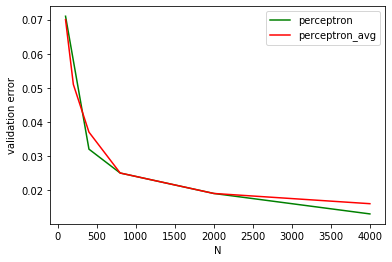

In [16]:
#plotting
plt.xlabel('N')
plt.ylabel('validation error')
plt.plot( N , e1,color ='green',label = "perceptron")
plt.plot( N , e2,color ='red',label = "perceptron_avg")
plt.legend()
plt.show()

8 (3 points) Also for N = 100, 200, 400, 800, 2000, 4000, create a plot of the number of
perceptron iterations as a function of N, where by iteration we mean a complete pass
through the training data. As the amount of training data increases, the margin of the
training set decreases, which generally leads to an increase in the number of iterations
perceptron takes to converge (although it need not be monotonic).


In [17]:
N = [100, 200, 400, 800, 2000,4000]
t = []
for n in N:
    w1,k1,t1 = perceptron_train(x_train[:n],y_train[:n],30)
    t.append(t1)

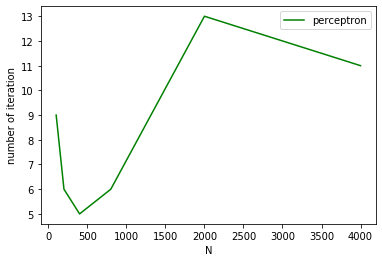

In [18]:
plt.xlabel('N')
plt.ylabel('number of iteration')
plt.plot(N,t,color ='green',label = "perceptron")
plt.legend()

9 (3 points) One consequence of this is that the later iterations typically perform updates
on only a small subset of the data points, which can contribute to overfitting. A way to
solve this is to control the maximum number of iterations of the perceptron algorithm. Add
an argument to both the perceptron and averaged perceptron algorithms that controls the
maximum number of passes over the data.
Try various configurations of the algorithms on your own using all 4000 training points,
and find a good configuration having a low error on your validation set. In particular, try
changing the choice of perceptron algorithm and the maximum number of iterations. Report the validation error for several of the configurations that you tried; which configuration
works best?

In [19]:
iterrs = [4,6,10,12,16,20]

for iterr in iterrs:
    w1,k1,t1 = perceptron_train(x_train,y_train,iterr)
    w2,k2,t2 = perceptron_train_avg(x_train,y_train,iterr)
    print("Perceptron: The Val_error for max_iteration as ", iterr ,"is: " ,perceptron_test(w1,x_val,y_val), "with iteration of: ", t1)
    print("Perceptron average: The Val_error for max_iteration as ", iterr ,"is: " ,perceptron_test(w2,x_val,y_val), "with iteration of: ", t2)
    print('                                                                       ')

Perceptron: The Val_error for max_iteration as  4 is:  0.023 with iteration of:  5
Perceptron average: The Val_error for max_iteration as  4 is:  0.016 with iteration of:  5
                                                                       
Perceptron: The Val_error for max_iteration as  6 is:  0.02 with iteration of:  7
Perceptron average: The Val_error for max_iteration as  6 is:  0.013 with iteration of:  7
                                                                       
Perceptron: The Val_error for max_iteration as  10 is:  0.013 with iteration of:  11
Perceptron average: The Val_error for max_iteration as  10 is:  0.016 with iteration of:  11
                                                                       
Perceptron: The Val_error for max_iteration as  12 is:  0.013 with iteration of:  11
Perceptron average: The Val_error for max_iteration as  12 is:  0.016 with iteration of:  11
                                                                       
Perceptro

10 (Optional) You could additionally change X from question 2.

In [20]:
#from 9, we get the max_iterr = 6 is the optimized with perceptron_avg algorithm
xs = [10,20,30,50]
for x in xs:
    voc = vocabulary(train_new.iloc[:,0],x)
    x_t = words_in_texts(voc,pd.Series(train_new.iloc[:,0]))
    y_t = train_new.loc[:,'spam']
    w3,k3,t3 = perceptron_train(x_train,y_train,6)
    w4,k4,t4 = perceptron_train_avg(x_train,y_train,6)
    print("Perceptron: The Validation error for X as", x ,"is: " ,perceptron_test(w3,x_val,y_val))
    print("Perceptron average: The Validation error for X as ", x ,"is: " ,perceptron_test(w4,x_val,y_val))
    

Perceptron: The Validation error for X as 10 is:  0.02
Perceptron average: The Validation error for X as  10 is:  0.013
Perceptron: The Validation error for X as 20 is:  0.02
Perceptron average: The Validation error for X as  20 is:  0.013
Perceptron: The Validation error for X as 30 is:  0.02
Perceptron average: The Validation error for X as  30 is:  0.013
Perceptron: The Validation error for X as 50 is:  0.02
Perceptron average: The Validation error for X as  50 is:  0.013


11 (3 points) You are ready to train on the full training set, and see if it works on completely
new data. Combine the training set and the validation set (i.e. use all of spam train.txt)
and learn using the best of the configurations previously found. What is the error on the
test set (i.e., now you finally use spam test.txt)?


In [24]:
#we choose max_iteration as 6 and perceptron_train_avg as our final algorithm
final_voc = vocabulary(train.iloc[:,0],30)
x_all = words_in_texts(final_voc,pd.Series(train.iloc[:,0]))
y_all = train.loc[:,'spam']
x_test = words_in_texts(final_voc,pd.Series(test.iloc[:,0]))
y_test = test.loc[:,'spam']
final_w, final_k,final_t = perceptron_train_avg(x_all,y_all,6)
test_error = perceptron_test(final_w,x_test,y_test)
print("The final test error on the best algorithm is",test_error)

The final test error on the best algorithm is 0.017


remark: the iteration in question 4 and 9 could be 10 or 6, depend on whether we take in account the last iteration or not(the last iteration won't update the weight)